# REINFORCE-K

We will implement a simple but powerful REINFORCE agent in PyTorch that directly backprop based on the methodology used by Andrej Karpathy. We will bypass PyTorch's recommended method of using torch.distribution's score function to implement reinforcement learning.

Wish me Luck!!!

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import platform
import gym
import pickle as pickle
import pympler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

# For memory tracking
from pympler import summary
from pympler import muppy

cpu_dtype = torch.FloatTensor
gpu_dtype = torch.cuda.FloatTensor

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.3


## REINFORCE-Karpathy for "Pong"

The following code uses the basic policy gradient method (REINFORCE) to train a 2 layer NN to play Pong.

The time needed to train 10 episodes is 13 sec with Intel I7 (4-cores). The forward pass takes 4 seconds. So implementing this in PyTorch and using GPU will speed things up by 30%.

In [ ]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle as pickle
import gym

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?

learning_rate  = 1e-3
epoch_reward_history=[]
    
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
  model = pickle.load(open('save.p', 'rb'))
else:
  model = {}
  model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
  model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
verbose = False
print_every = 20
reward_sum = 0
episode_number = 0
forward_time=0
backward_time=0
other_time = 0

start = time.time()

while episode_number < 30000:
  if render: env.render()

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
  t1 = time.time()
  aprob, h = policy_forward(x)
  action = 2 if np.random.uniform() < aprob else 3 # roll the dice!
  t2 = time.time()
  forward_time += t2-t1

  # record various intermediates (needed later for backprop)
  xs.append(x) # observation
  hs.append(h) # hidden state
  y = 1 if action == 2 else 0 # a "fake label"
  dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
  t5 = time.time()  
  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward

  t6 = time.time()
  other_time += t6-t5

  drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

  if done: # an episode finished
    episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(xs)
    eph = np.vstack(hs)
    epdlogp = np.vstack(dlogps)
    epr = np.vstack(drs)
    xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
    discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_epr -= np.mean(discounted_epr)
    discounted_epr /= np.std(discounted_epr)

    epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
    
    t3 = time.time()    
    grad = policy_backward(eph, epdlogp)
    t4 = time.time()
    backward_time += t4-t3    
    
    for k in model: 
        grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
    if episode_number % batch_size == 0:
      for k,v in model.items():
        g = grad_buffer[k] # gradient
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    if episode_number % print_every == 0:     
        print ('Episode %d - reward total was %f. running mean: %f' % (episode_number, reward_sum, running_reward))

    epoch_reward_history.append([reward_sum, running_reward])
    if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
    reward_sum = 0
    observation = env.reset() # reset env
    prev_x = None

  if reward != 0 and verbose: # Pong has either +1 or -1 reward exactly when game ends.
    print (('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))
    
end = time.time()
print ("Time to complete", end-start)
print ("Time to forward pass", forward_time)
print ("Time to backward pass", backward_time)
print ("Time to other stuffs", other_time)

## REINFORCE-K

After the great professor and mentor.

In [41]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = weight_shape[1]
        m.weight.data.normal_(0, math.sqrt(2. / fan_in))  # Xavier for ReLU
        m.bias.data.fill_(0)


# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong (a resampled 40x40 diff image of 2 successive frames )
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
            
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.affine2 = nn.Linear(200, 2)  
        self.apply(weights_init)
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return action_scores   # output logit
    


In [16]:
def prepro80(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def estimate_Q(r, gamma):
  """ 
  take 1D float array of rewards and compute discounted reward --> Estimating Q(s,a)
  """
  r = np.array(r)  # convert list to numpy

  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0:   # reset the sum, since this was a game boundary specific to Pong.
        running_add = 0 
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    
    # Use Policy to generate probability for action
    logit = policy(Variable(state.type(gpu_dtype), requires_grad=False))

    # Replace PyTorch recommended RL implementation
    # Sample action stochastically    
    # m = Categorical(probs)
    # action = m.sample()

    prob = F.softmax(logit, dim=1)
    log_prob = F.log_softmax(logit, dim=1)
    action = prob.multinomial().data   # action is sampled here
    
    if verbose:
        print ("Pong's state output:", state.shape)
        print ("NN output:", logit)
        print ("Pong Action:", action)
        print ("log_prob(action):", log_prob)
        
    log_prob = log_prob.gather(1, Variable(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(log_prob)
    
    if verbose:
        print ("Stacked log_prob:", policy.saved_log_probs)
    
    return action

def finish_batch():
    """ 
    Based on REINFORCE, policy gradient is computed at the end of a batch (instead of an
    episode). It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:    
        print ("Rewards:", policy.rewards)
            
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        if r != 0:  # reset the sum, since this was a game boundary (pong specific!)
            R = 0
        R = r + gamma * R
        rewards.insert(0, R)
        
    if verbose:    
        print ("Discounted Rewards:", rewards)
       
    rewards = torch.Tensor(rewards)
    
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del policy.rewards[:]
    del policy.saved_log_probs[:]


In [65]:
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

gamma=0.99
render=False
verbose=False  # To step through the code and understand what is going on
log_interval=10
play_steps = 800  # number of game steps before we calculate policy gradient
gradient_batch = 10   # number of policy gradients to batch before updating the policy
lr = 1e-4 

reinforce=[]
env = gym.make("Pong-v0")

# D_in is input dimension; H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 6400, 200, 2

# Randomly initialize weights
if torch.cuda.is_available():
    W1 = torch.randn(D_in, H).type(gpu_dtype)/math.sqrt(2./D_in)
    W2 = torch.randn(H, D_out).type(gpu_dtype)/math.sqrt(2./H)
else:
    W1 = torch.randn(D_in, H).type(cpu_dtype)/math.sqrt(2./D_in)
    W2 = torch.randn(H, D_out).type(cpu_dtype)/math.sqrt(2./H) 

dW1_buffer = None
dW2_buffer = None

        
# Main loop
prev_x = None
running_reward = -15
start = time.time()

for i_episode in range(1000+1): # run 30000 episode    
    state = env.reset()
    reward_sum = 0
    
    # Clear out the stacked local gradients
    eph = None
    epdlogp = None
    epx = None
    epr = None
    rewards = []
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Downsample 210x160x3 frame into 6400 (80x80) 1D float vector
        cur_x = prepro80(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
        prev_x = cur_x
        
        """
        Sample an action from Policy based on state provided by env
        (Entering Torch(GPU/CPU) Land!!!)
        """
        state = torch.from_numpy(state).float().unsqueeze(0)   # state: numpy-->Tensor

        # 2-layer Neural Network - Forward Pass
        #  Input - state
        #  Output - logp
    
        # Stage 1 - Matrix Multiplication                               #[1]    
        h = state.mm(W1)
        # Stage 2 - ReLU                                                #[2]    
        h_relu = h.clamp(min=0)
        # Stage 3 - Matrix Multiplication                               #[3]    
        logp = h_relu.mm(W2)

        # A Pong action is sampled from the Softmax Classifier
        prob = F.softmax(Variable(logp), dim=1)
        sample = prob.multinomial().data  
        
        if verbose:
            print("Softmax prob:", prob)
            print("Sampled output:", sample)
        """
        Stack local gradients for policy update at the end of episode/batch
        """
        
        y = torch.zeros(1, D_out).scatter_(1,torch.LongTensor(sample) ,1)
        dlogp = y - prob.data

        epdlogp =  torch.cat((epdlogp, dlogp), 0) if epdlogp is not None else dlogp
        eph = torch.cat((eph, h), 0) if eph is not None else h
        epx = torch.cat((epx, state), 0) if epx is not None else state
        
        if verbose: 
            print("y-prob: ", dlogp)
            print("Stacked y-prob: ", epdlogp.size())    
            print("Stacked h: ",eph.size())    
            print("Stacked x: ",epx.size()) 
            
        """
        Advance one step in the Pong env using action sampled 
        (Exit Torch(GPU/CPU) Land. Now in Numpy-CPU Land!!!)
        """
        
        action = sample.cpu().numpy() + 2   # action: Tensor --> numpy
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)  # UP=2, DOWN=3
        reward_sum += reward
        if render:
            env.render() 
            
        """
        Stack rewards for policy update at the end of episode/batch
        """
        rewards.append(reward)     
        if verbose: 
            print("Pong action: ",action)
            print("Stacked rewards: ",rewards) 
        
        # Time to update policy - episode done or game steps exceed a preset value
        if done or t > update_interval:
            break
            
    """ 
    In REINFORCE, policy gradient is computed at the end of a batch/episode and then 
    used to update the Policy's weights
    """
    if verbose:
        print ("We have finished a batch/episode. We now calculate policy gradient. \n")  
    
    """
    While the agent is playing, reward for each time step is stored in rewards[].
    At the end of the episode, this is used to generate Q(s,a) for each time step.
    (Exit Numpy-CPU Land. Now in Torch(GPU/CPU) Land!!!)
    """
    
    Q = estimate_Q(rewards, gamma)
    epq = torch.from_numpy(Q).float().view(-1,1)  # reshape to Nx1 where N = # play steps
   
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    epq = (epq - epq.mean()) / (epq.std() + np.finfo(np.float32).eps)
    
    epdlogp *= epq  # modulate the gradient with advantage (PG magic happens right here.) 
    
    if verbose:
        print ("Stacked Q(s,a): ",epq) 
        print ("Stacked Q(s,a)*(y-prob): ", epdlogp) 

    # 2-layer Neural Network - Backward Pass
    #  Input - epdlogp
    #  Output - dW1, dW2

    # Stage 3 - BackProp Matrix Multiplication                               #[3]
    # logp = h_relu.mm(W2)
    dW2 = torch.transpose(eph, 0, 1).mm(epdlogp)
    dh = epdlogp.mm(torch.transpose(W2,0,1))
    
    # Stage 2 - Backprop ReLU                                                #[2]    
    # h_relu = h.clamp(min=0)
    dh[eph <= 0] = 0 

    # Stage 1 - Matrix Multiplication                               #[1]    
    # h = state.mm(W1)
    dW1 = torch.transpose(epx, 0, 1).mm(dh)
    
    if verbose:
        print("dW2: ",dW2.size())
        print("dh_relu: ",dh.size())
        print("dh: ",dh.size())
        print("dW1: ",dW1.size())
        
    dW1_buffer = torch.add(dW1_buffer, dW1) if dW1_buffer is not None else dW1
    dW2_buffer = torch.add(dW2_buffer, dW2) if dW2_buffer is not None else dW2

    # After a number of gradients have been batched, update policy weights using gradient descent
    if (i_episode+1) % gradient_batch == 0:
        W1 += lr * dW1_buffer
        W2 += lr * dW2_buffer
        dW1_buffer = None
        dW2_buffer = None


    # Keep track of running reward
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    reinforce.append([reward_sum, running_reward])
    
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                i_episode, reward_sum, running_reward))
    
    # save model every 4000 episodes
    if i_episode % 4000 == 0:
        model = {}
        model['W1'] = W1
        model['W2'] = W2
        pickle.dump(model, open('save.p', 'wb'))

end = time.time()
print ("Time taken:", start-end)
env.close()


Episode 0	Last Reward: -14.00	Running Reward: -14.99
Episode 10	Last Reward: -14.00	Running Reward: -14.75
Episode 20	Last Reward: -12.00	Running Reward: -14.51
Episode 30	Last Reward: -13.00	Running Reward: -14.25
Episode 40	Last Reward: -13.00	Running Reward: -14.04
Episode 50	Last Reward: -12.00	Running Reward: -13.89
Episode 60	Last Reward: -9.00	Running Reward: -13.68
Episode 70	Last Reward: -11.00	Running Reward: -13.57
Episode 80	Last Reward: -5.00	Running Reward: -13.38
Episode 90	Last Reward: -12.00	Running Reward: -13.29
Episode 100	Last Reward: -12.00	Running Reward: -13.18
Episode 110	Last Reward: -14.00	Running Reward: -13.11
Episode 120	Last Reward: -11.00	Running Reward: -13.05
Episode 130	Last Reward: -10.00	Running Reward: -12.96
Episode 140	Last Reward: -14.00	Running Reward: -12.92
Episode 150	Last Reward: -12.00	Running Reward: -12.79
Episode 160	Last Reward: -13.00	Running Reward: -12.71
Episode 170	Last Reward: -14.00	Running Reward: -12.68
Episode 180	Last Reward

In [66]:
name = 'reinforce-k-lr=1e-3'
history_file = './results/reinforce/pong_'+name+'ep='+str(i_episode+1)+'history.p'
pickle.dump(reinforce, open(history_file, 'wb'))

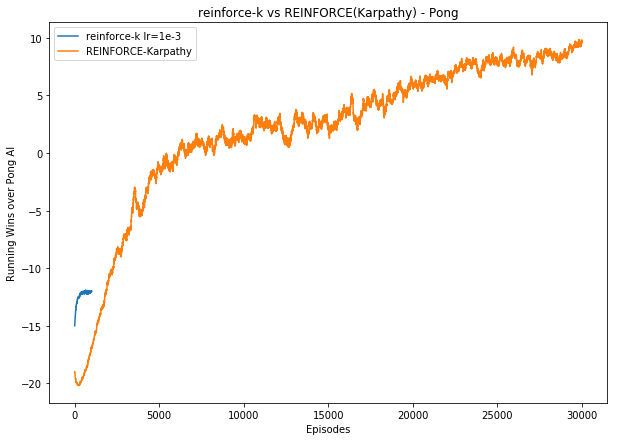

In [67]:
data1 = pickle.load(open('./results/reinforce/pong_reinforce-k-lr=1e-3ep=1001history.p', 'rb'))
data2 = pickle.load(open('./results/pg-numpy/reward_history-pg-numpy-30000ep-lr-1e-3.p', 'rb'))

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))


plt.plot(list(range(1,len(data1)+1)), np.array(data1)[:,1], label='reinforce-k lr=1e-3')
plt.plot(list(range(1,len(data2)+1)), np.array(data2)[:,1], label='REINFORCE-Karpathy')
plt.title('reinforce-k vs REINFORCE(Karpathy) - Pong')
plt.xlabel('Episodes')
plt.ylabel('Running Wins over Pong AI')
plt.legend()
plt.show()

In [12]:
x = np.array([2.0])
print (x)

y = torch.from_numpy(x).float()
print (y)

y = torch.cat((y,y),0)

print (y)

[ 2.]

 2
[torch.FloatTensor of size 1]


 2
 2
[torch.FloatTensor of size 2]



In [57]:
model = pickle.load(open('save.p', 'rb'))

print (model['W1'])


-1.1776e+01 -5.4662e+01 -6.4076e+01  ...   2.2455e+00  8.0946e+00  4.8980e+01
-3.8046e+01 -9.9706e+01 -1.6747e+00  ...  -6.9307e+00  5.2662e+00  6.4510e+01
-3.3685e+01 -1.4248e+01  5.1007e+01  ...   1.3964e+02 -2.8429e+01 -1.7248e+01
                ...                   ⋱                   ...                
 1.6935e+01 -6.1469e+01  2.1259e+01  ...   4.1310e+01 -3.9917e+01 -6.9136e+01
 1.0329e+01 -2.1218e+01 -4.6218e+01  ...  -1.9701e+01  4.9976e+01  1.7643e+01
-7.0451e+01 -3.4414e+00  1.3894e-01  ...   8.3061e+01  1.5964e+01 -2.4826e+00
[torch.FloatTensor of size 6400x200]

